# ROC Calculation Functions

Function roc_calc is to calculate roc value for one score. 
* Score can be either first stage score or second stage bad rate 
* Value of the target column must be GOOD/BAD/INDET. Case doesn't matter. 
* Function returns a float. 

Function roc_calc_multi is to calculate roc values for one or multiple scores. 
* Function calls roc_calc to calculate roc for every score that we pass in. 
* Function returns a Series of roc for all scores. 

Function roc_plot is to plot roc curve for one or multiple scores.

In [15]:
# Function Definition. 
def roc_calc(df, target_name, score_name):
    import pandas as pd
    import numpy as np
    
    df[target_name] = df[target_name].str.upper()
    df = df[(df[target_name] == 'GOOD') | (df[target_name] == 'BAD')]
    piv = df.pivot_table(df,index=score_name,columns=target_name,aggfunc='size',fill_value=0)
    
    if piv.index.max() <= 1:    # if it's second stage bad rate, sort from high to low
        piv = piv.sort_index(ascending=False)
    
    else:                       # if it's first stage score, sort from low to high
        piv = piv.sort_index()

    piv['Bad%'] = (piv.BAD.cumsum(axis=0))/(piv.BAD.sum())
    piv['Good%'] = (piv.GOOD.cumsum(axis=0))/(piv.GOOD.sum())
    piv = piv.reset_index()
    
    roc = 0
    for i in range(len(piv)-1):
        roc += (piv['Good%'].iloc[i+1] - piv['Good%'].iloc[i]) * (piv['Bad%'].iloc[i+1] + piv['Bad%'].iloc[i])
    return roc*0.5


def roc_calc_multi(df, target_name, *score_name):
    import pandas as pd
    import numpy as np
    
    result = {}
    for score in score_name:
        result[score] = roc_calc(df,target_name,score)
    result = pd.Series(result)
    result.name = 'ROC'
    return result
    
    
def roc_plot(df, target_name, *score_name):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df[target_name] = df[target_name].str.upper()
    df = df[(df[target_name] == 'GOOD') | (df[target_name] == 'BAD')]
    
    fig = plt.figure(figsize=(6,6))
    
    for score in score_name:
        piv = df.pivot_table(df,index=score,columns=target_name,aggfunc='size',fill_value=0)
        if piv.index.max() <= 1:    # if it's second stage bad rate, sort from high to low
            piv = piv.sort_index(ascending=False)
        else:                       # if it's first stage score, sort from low to high
            piv = piv.sort_index()
        piv['Bad%'] = (piv.BAD.cumsum(axis=0))/(piv.BAD.sum())
        piv['Good%'] = (piv.GOOD.cumsum(axis=0))/(piv.GOOD.sum())
        piv = piv.reset_index()
        roc = 0
        for i in range(len(piv)-1):
            roc += (piv['Good%'].iloc[i+1] - piv['Good%'].iloc[i]) * (piv['Bad%'].iloc[i+1] + piv['Bad%'].iloc[i])
        roc *= 0.5 
        plt.plot(piv['Good%'], piv['Bad%'], lw=2, label = "{} {:.4f}".format(score, roc))
        
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('Cumulative % of Goods')
    plt.ylabel('Cumulative % of Bads')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

In [6]:
# Set up!
import pandas as pd
import numpy as np
    
# Put in the path of the data file inside of the apostrophe
path = r'\\neptune\RAD\4 Models\Scorecard 7.0\Subpopulation Study\Lift\data prepare\DEV\Total.csv'

# Load the data file
df = pd.read_csv(path)

In [42]:
# Example: calculate roc for a single score
roc_calc_multi(df, 'G_B', 'SC60_Stage1_Points')

SC60_Stage1_Points    0.697617
Name: ROC, dtype: float64

In [43]:
# Example: calculate roc for multiple scores
roc_calc_multi(df, 'G_B', 'SC60_Stage1_Points', 'SC60_Stage2_Points', 'SC70_Stage1_Points', 'SC70_Stage2_Points')

SC60_Stage1_Points    0.697617
SC60_Stage2_Points    0.711602
SC70_Stage1_Points    0.711558
SC70_Stage2_Points    0.725188
Name: ROC, dtype: float64

In [47]:
# Example: calculate roc for multiple scores group by Segment column

df.groupby('SC70_Segment').apply(roc_calc_multi,'G_B', 'SC60_Stage1_Points',\
                                 'SC60_Stage2_Points', 'SC70_Stage1_Points', 'SC70_Stage2_Points')

ROC,SC60_Stage1_Points,SC60_Stage2_Points,SC70_Stage1_Points,SC70_Stage2_Points
SC70_Segment,,,,
7A,0.677731,0.692681,0.706034,0.718842
7B,0.674665,0.688571,0.694914,0.709224
7C,0.666813,0.679076,0.692968,0.707052
7D,0.712364,0.726274,0.717424,0.731038
7E,0.689806,0.705966,0.704998,0.718360
7F,0.724936,0.737701,0.727495,0.739916
7G,0.707950,0.719136,0.735889,0.745777
7H,0.713438,0.727140,0.730124,0.742720
7I,0.682888,0.697266,0.687413,0.702477


In [45]:
# Example: calculate roc for multiple scores group by State and Seg columns

# Define FICO Segment and State Group
seg_map = {
    '7A': 'Valid',
    '7B': 'Valid',
    '7C': 'Valid',
    '7D': 'Valid',
    '7E': 'Valid',
    '7F': 'Valid',
    '7G': 'Valid',
    '7H': 'Valid',
    '7I': '9000s',
    '7J': '9000s',
    '7K': '9000s',
    '7L': '9000s',
    '7M': 'Missing',
    '7N': 'Missing'
}

state_map = {
    'CA': 'CA',
    'TX': 'TX',
    'FL': 'FL',
    'AZ': 'Others',
    'CO': 'Others',
    'ID': 'Others',
    'MN': 'Others',
    'NM': 'Others',
    'NV': 'Others',
    'OR': 'Others',
    'UT': 'Others',
    'WA': 'Others',
    'WY': 'Others'
}

df['Seg_FICO'] = df['SC70_Segment'].map(seg_map)
df['State_Group'] = df['Model_State'].map(state_map)

# Run ROC function to calculate ROC within each state and segment.
df.groupby(['State_Group','Seg_FICO']).apply(roc_calc_multi,'G_B', 'SC60_Stage1_Points', 'SC60_Stage2_Points', \
                                             'SC70_Stage1_Points', 'SC70_Stage2_Points')

ROC                   SC60_Stage1_Points  SC60_Stage2_Points  \
State_Group Seg_FICO                                           
CA          9000s               0.682888            0.697266   
            Missing             0.593959            0.662608   
            Valid               0.712173            0.724821   
FL          9000s               0.664344            0.678896   
            Missing             0.547091            0.606406   
            Valid               0.721664            0.733995   
Others      9000s               0.658276            0.665514   
            Missing             0.635129            0.649405   
            Valid               0.707004            0.718162   
TX          9000s               0.663899            0.676130   
            Missing             0.589351            0.625757   
            Valid               0.700304            0.712645   

ROC                   SC70_Stage1_Points  SC70_Stage2_Points  
State_Group Seg_FICO                                          
CA          9000s               0.687413            0.702477  
            Missing             0.601685            0.660319  
            Valid               0.724650            0.736775  
FL          9000s               0.673044            0.686429  
            Missing             0.549321            0.604493  
            Valid               0.727314            0.740062  
Others      9000s               0.682075            0.690184  
            Missing             0.616072            0.633016  
            Valid               0.731658            0.742830  
TX          9000s               0.666372            0.680186  
            Missing             0.592220            0.625324  
            Valid               0.715987            0.728502

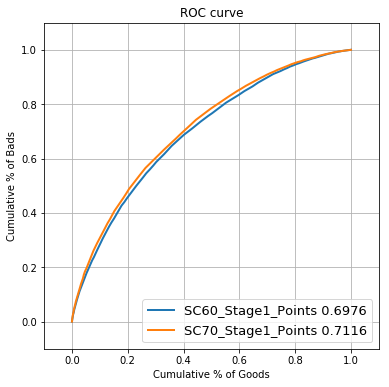

In [16]:
# Example: plot the roc curve for one or multiple scores
roc_plot(df, 'G_B', 'SC60_Stage1_Points', 'SC70_Stage1_Points')